In [1]:
# Tested with kernel "LCLS-II py3"

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline 
%config InlineBackend.figure_format ='retina'

In [3]:
import os
os.getcwd()

'/cds/home/b/bwt/MeV-UED'

In [4]:
from ued_data_analysis import file_to_h5, ord_dict, UED_Exp, find_center, quads_class

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.patches import Arrow, Circle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy import optimize


In [15]:
#fn = "20201117_1825_quads.h5"
#fn = "20201117_2133_quads.h5"
#fn = '20201118_1554_quads.h5'
#fn = '20201118_2322_quads.h5'
fn = '20201118_1554_quads_guess.h5' # used a guess for the center, watch out for center finding algorithm problems

In [16]:
Exp = quads_class()

In [17]:
Exp.load_quads(fn)

20201118_1554_quads_guess.h5
Keys: <KeysViewHDF5 ['delays_dict', 'delays_mask', 'delays_unique', 'quadsN_0', 'quadsN_1', 'quadsN_2', 'quadsN_3', 'stage_t0']>
delays_dict: <HDF5 group "/delays_dict" (31 members)>
delays_mask: <HDF5 dataset "delays_mask": shape (2321,), type "<i8">
delays_unique: <HDF5 dataset "delays_unique": shape (31,), type "<f8">
quadsN_0: <HDF5 dataset "quadsN_0": shape (2375, 450), type "<f8">
quadsN_1: <HDF5 dataset "quadsN_1": shape (2375, 450), type "<f8">
quadsN_2: <HDF5 dataset "quadsN_2": shape (2375, 450), type "<f8">
quadsN_3: <HDF5 dataset "quadsN_3": shape (2375, 450), type "<f8">
stage_t0: <HDF5 dataset "stage_t0": shape (1,), type "<f8">
delays_unique [161.12321    161.1981575  161.273105   161.2880945  161.303084
 161.31057875 161.3180735  161.32556825 161.333063   161.34055775
 161.3480525  161.35554725 161.363042   161.37053675 161.3780315
 161.38552625 161.393021   161.40051575 161.4080105  161.41550525
 161.423      161.43049475 161.4379895  161.4

In [30]:
# This is what you have to work with!
[f for f in dir(Exp) if not f.startswith('__')]

['delays_dict',
 'delays_mask',
 'delays_unique',
 'filename',
 'load_quads',
 'maxRadius',
 'meanquadsN',
 'quadrants_stats',
 'quadsN',
 'save_quads',
 'set_params',
 'stage_t0',
 'stdquadsN',
 'useQuadrants']

In [18]:
print(Exp.quadsN.shape[0], Exp.delays_mask.shape[0], abs(Exp.delays_mask.shape[0]-Exp.quadsN.shape[0])/Exp.quadsN.shape[0], "% discarded")

2375 2321 0.02273684210526316 % discarded


(76, 450)


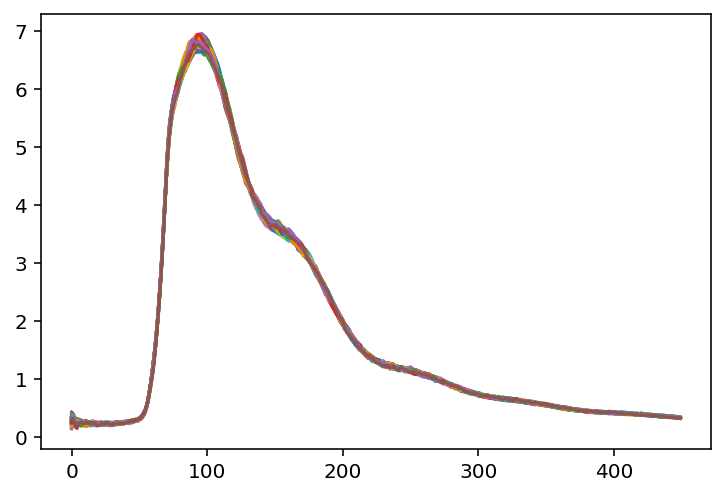

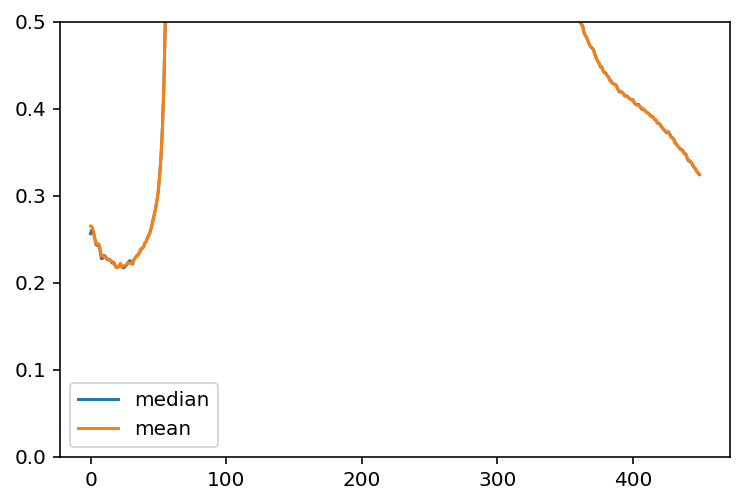

In [19]:
def plot_quadsN(delay=161.273105, quad=1):
    idxs = Exp.delays_dict[delay]
    d = Exp.quadsN[idxs,:,quad]
    print(d.shape)
    plt.plot(np.transpose(d))
    plt.show()
    
    plt.plot(np.median(d, axis=0), label='median')
    plt.plot(np.mean(d, axis=0), label='mean')
    plt.legend()
    plt.ylim(0,0.5)
    plt.show()
    
plot_quadsN()    

(76,)


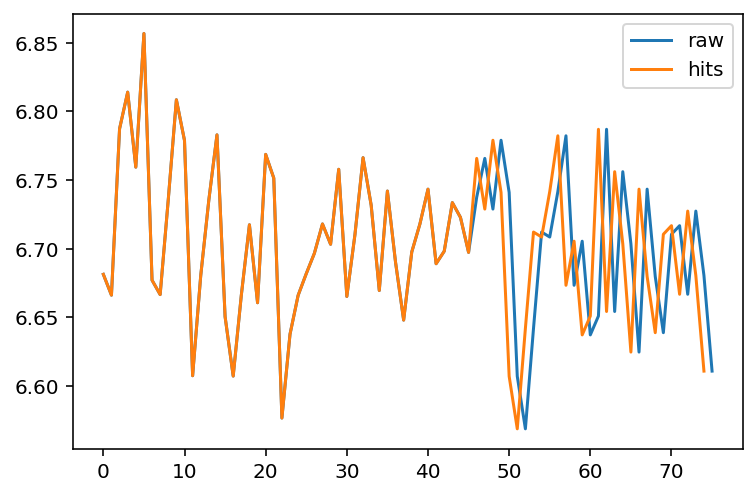

In [20]:
def take_pixel(delay=161.273105, quad=1, pixel=100):
    idxs = Exp.delays_dict[delay]
    d = Exp.quadsN[idxs,pixel,quad] # QuadsN is raw data, no outliers removed
    print(d.shape)
    plt.plot(d, label="raw")
    
    hit_idxs = np.intersect1d(idxs, Exp.delays_mask)
    d_hit = Exp.quadsN[hit_idxs,pixel,quad]
    plt.plot(d_hit, label="hits")
    plt.legend()
    
    return d
    
take_pixel(); # WARNING, looking at a single pixel!!

In [21]:
def test_part_A(delay=161.273105, quad=1, split=4):
    idxs = Exp.delays_dict[delay]
    idxs_split = np.array_split(idxs,split) # array_split handles split without unequal subarray error
    
    d = Exp.quadsN[idxs,:,quad]
    print(d.shape)
    dMean = np.mean(d,axis=0)    
        
    d2 = [Exp.quadsN[idx,:,quad] for idx in idxs_split]
    print(d2[0].shape)
    d3 = np.array([np.mean(split,axis=0) for split in d2]) 
    print(d3.shape)
    
    lineObjects = plt.plot(np.transpose(d3))
    plt.legend(lineObjects, np.arange(split))
    plt.xlabel('Pixel'), plt.ylabel('Total Diffraction')
    plt.show()
        

    dDiff = d3 - dMean
    dDiff.shape
    #print(d4)
    lineObjects = plt.plot(np.transpose(dDiff))
    plt.legend(lineObjects, np.arange(split))
    plt.xlabel('Pixel'), plt.ylabel('Diffraction - mean Diffraction')
    plt.show()

#test_part_A();

In [22]:
def test_part(delay=161.273105,  split=4, verbose=True):
    """For all quadrants, using only hits"""
    idxs = Exp.delays_dict[delay]
    hit_idxs = np.intersect1d(idxs, Exp.delays_mask)
    idxs_split = np.array_split(hit_idxs,split) # array_split handles split without unequal subarray error
    
    d = Exp.quadsN[hit_idxs,:,:]
    #print(d.shape)
    dMean = np.mean(d,axis=0)    
        
    d2 = [Exp.quadsN[idx,:,:] for idx in idxs_split]
    #print("First split shape:", d2[0].shape)
    d3 = np.array([np.mean(split,axis=0) for split in d2]) 
    print("Split shape (split x pixel x quadrant):", d3.shape)
    
    dDiff = d3 - dMean
    #print(dDiff.shape) 
    
    if verbose:
        lineObjects = plt.plot(np.transpose(d3))
        plt.legend(lineObjects, np.arange(split))
        plt.xlabel('Pixel'), plt.ylabel('Total Diffraction')
        plt.show()
        
        lineObjects = plt.plot(np.transpose(dDiff))
        plt.legend(lineObjects, np.arange(split))
        plt.xlabel('Pixel'), plt.ylabel('Diffraction - mean Diffraction')
        plt.show()
        
    return d3

In [23]:
Exp.delays_unique

array([161.12321   , 161.1981575 , 161.273105  , 161.2880945 ,
       161.303084  , 161.31057875, 161.3180735 , 161.32556825,
       161.333063  , 161.34055775, 161.3480525 , 161.35554725,
       161.363042  , 161.37053675, 161.3780315 , 161.38552625,
       161.393021  , 161.40051575, 161.4080105 , 161.41550525,
       161.423     , 161.43049475, 161.4379895 , 161.44548425,
       161.452979  , 161.46047375, 161.4679685 , 161.482958  ,
       161.512937  , 161.542916  , 161.572895  ])

In [25]:
splitOut = [test_part(delay=dly, verbose=False, split=6) for dly in Exp.delays_unique]
np.array(splitOut).shape

Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape (split x pixel x quadrant): (6, 450, 4)
Split shape 

(31, 6, 450, 4)

(31, 450)
(31, 450)
(31, 450)
(31, 450)
(31, 450)
(31, 450)


[None, None, None, None, None, None]

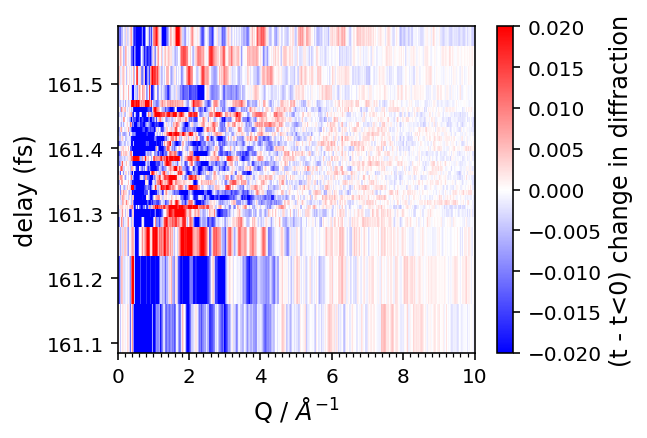

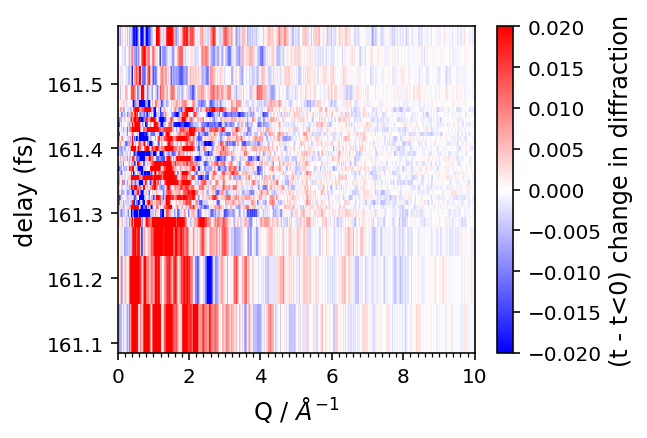

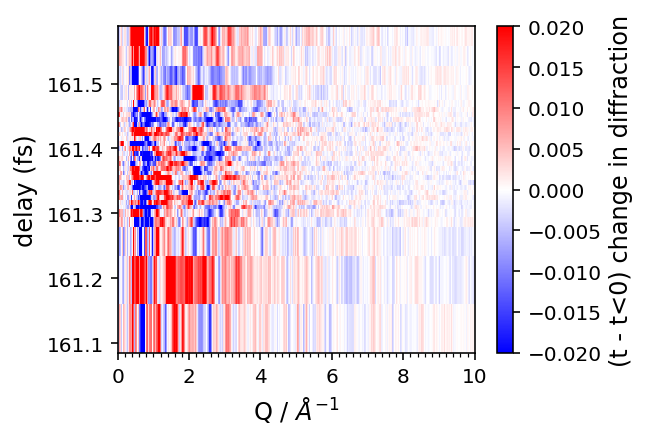

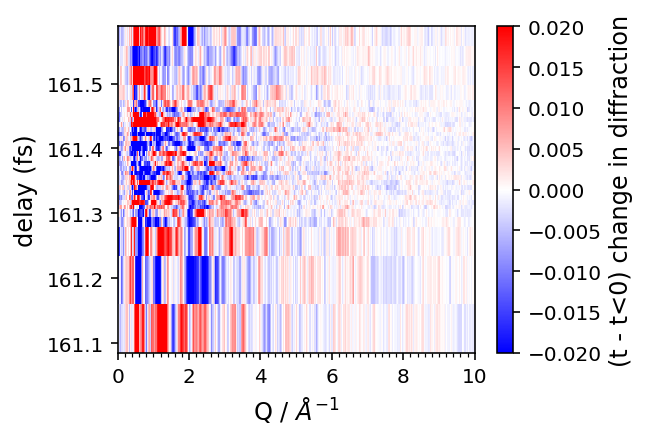

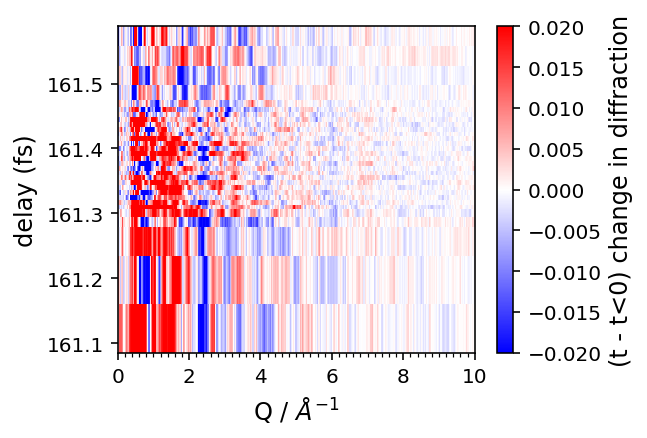

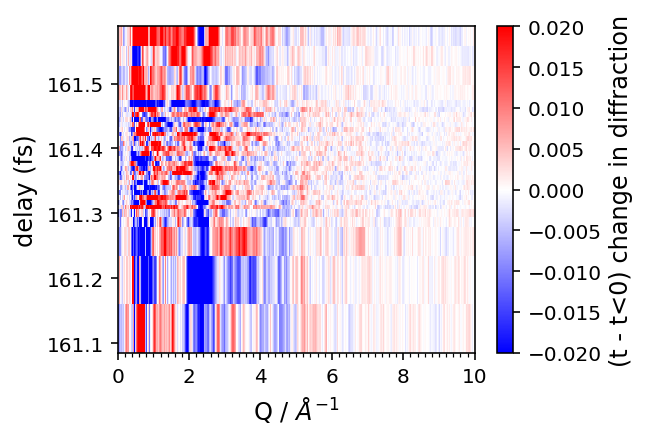

In [26]:
negT = np.mean(splitOut[-5:-1],axis=0)

splitOutSub = (splitOut - negT)

def plot_2Ddata(data, title="", vscale=0.02):
    print(data.shape)
    
    taxis = Exp.delays_unique
    qaxis = np.linspace(0,Exp.maxRadius*0.02355,Exp.maxRadius)
    fig, ((ax1)) = plt.subplots(ncols=1, nrows=1, figsize=(4,3))
    cartim1 = ax1.pcolormesh(qaxis,taxis,data, shading='auto', cmap=cm.bwr, vmin=-vscale, vmax=vscale)
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.set_xlim(0,10)
    ax1.set_title(title)
    ax1.set_xlabel('Q / $\AA^{-1}$', fontsize='large'), ax1.set_ylabel('delay (fs)', fontsize='large')
    cbar = plt.colorbar(cartim1, ax=ax1)
    cbar.set_label("(t - t<0) change in diffraction", fontsize='large')

    
splitOutSubSwap = np.swapaxes(splitOutSub,0,1)  # just reshuffling the indexes, like a transpose but we can pick any axes
splitOutSubSwap.shape
    
quad = (0,1,2,3)    
[plot_2Ddata(s) for s in np.mean(splitOutSubSwap[:,:,:,quad], axis=-1)]

(31, 450)


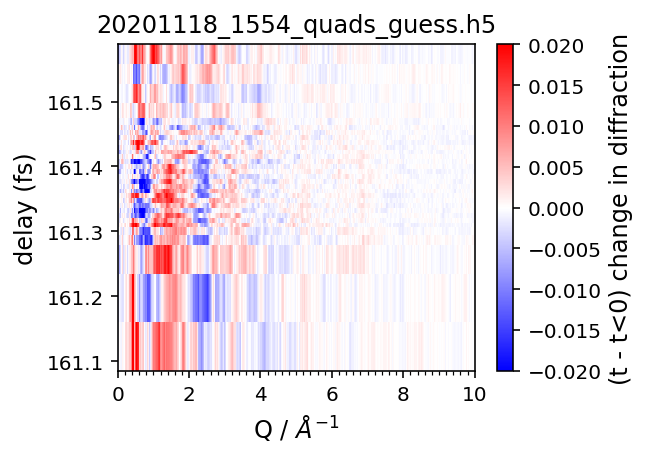

In [27]:
#sanity check that the split above works:
s_mean = np.mean(splitOutSubSwap[:,:,:,quad], axis=(0,-1))
plot_2Ddata(s_mean, title=Exp.filename)

In [28]:
# Notes: 
#Using split to look at different segments of the 1554 dataset shows it is extremely noisy

(31, 450)


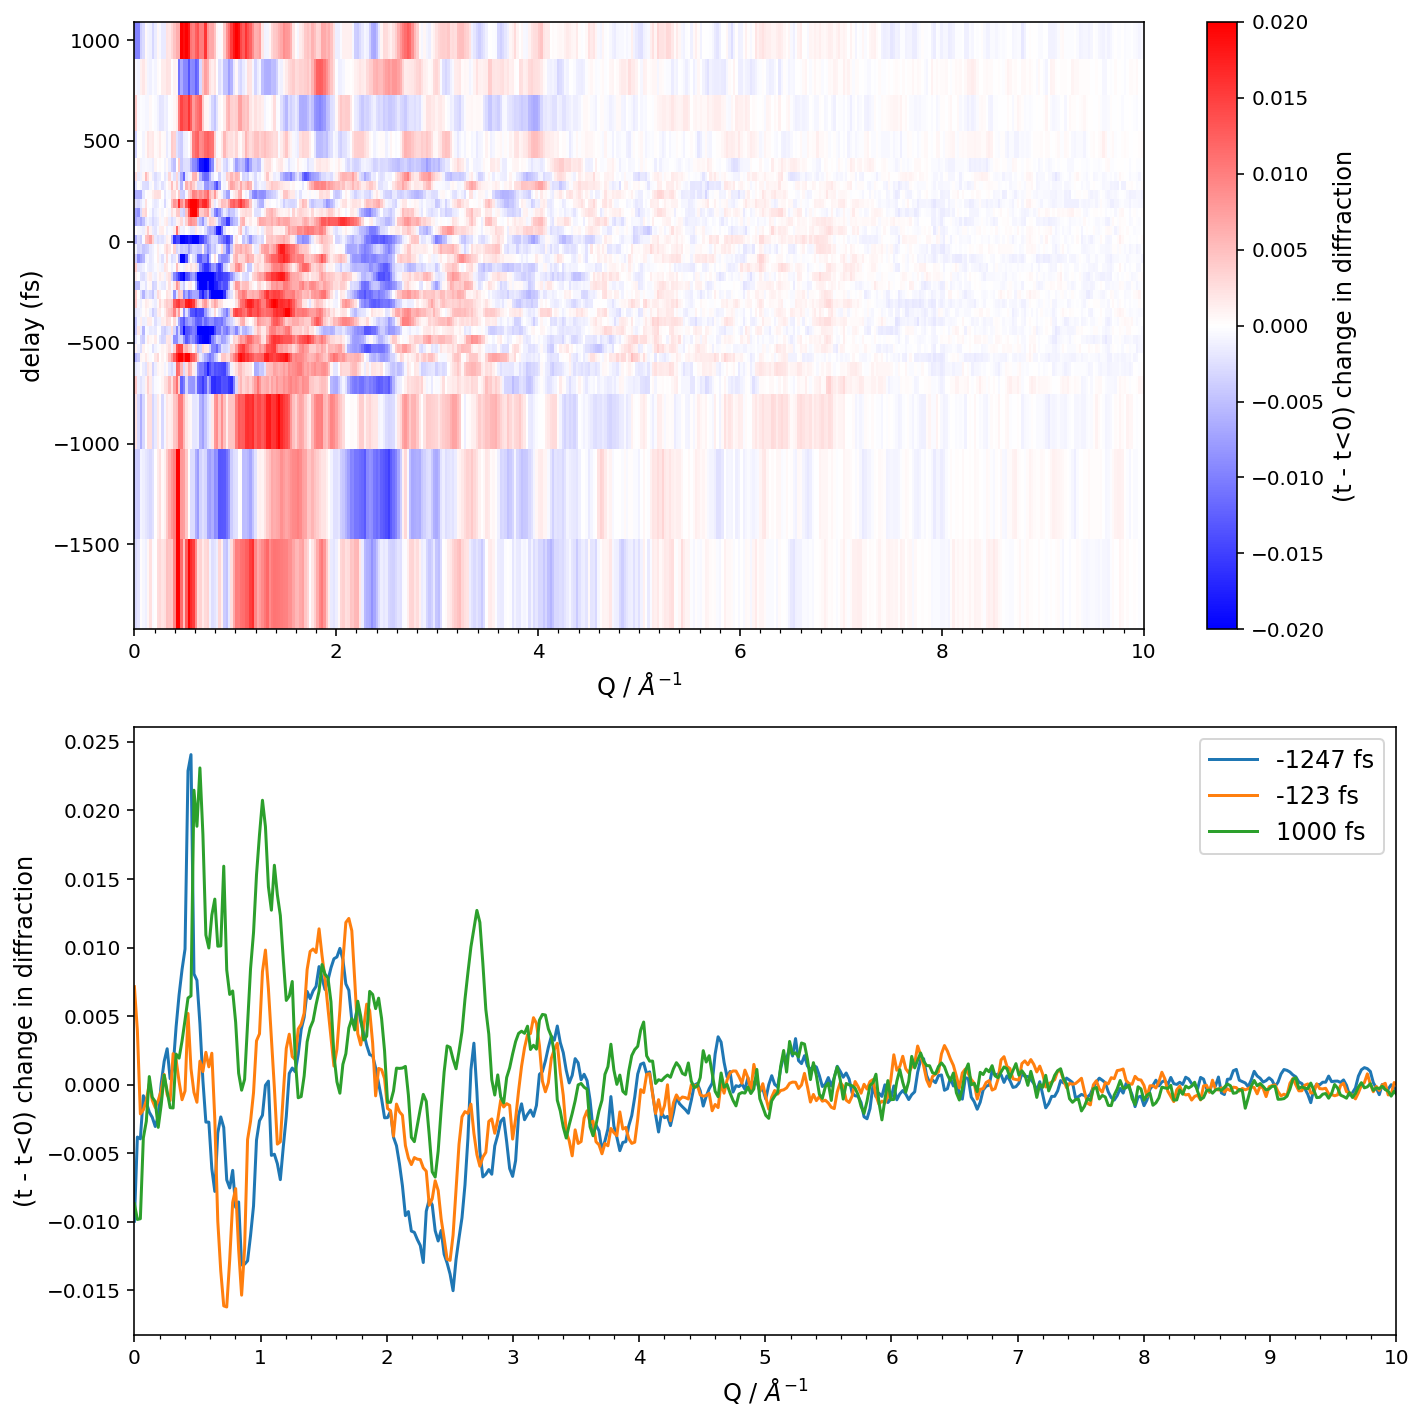

In [31]:
cart_pix = 300
delays = [1, len(Exp.delays_unique)//2, -1]
sub = [-5,-1] # delays to subtract
#labels = [f'{Exp.delays_unique[step]}' for step in delays]

# vmin=vmin1, vmax=vmax1*2,
fig, ((ax1), (ax4)) = plt.subplots(ncols=1, nrows = 2, figsize=(10,10))

c = 299792458
t0 = +1000
taxis = t0 + (Exp.delays_unique-max(Exp.delays_unique))*2*c/1E5
labels = [f'{t:.0f} fs' for t in taxis]
qaxis = np.linspace(0,Exp.maxRadius*0.02355,Exp.maxRadius)
data = np.mean(Exp.meanquadsN[:,:,:],axis=2)-np.mean(Exp.meanquadsN[sub[0]:sub[1],:,:],axis=(0,2))
print(data.shape)

cartim1 = ax1.pcolormesh(qaxis,taxis,data, shading='auto', cmap=cm.bwr, vmin=-0.02, vmax=0.02)
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.set_xlim(0,10)
ax1.set_xlabel('Q / $\AA^{-1}$', fontsize='large'), ax1.set_ylabel('delay (fs)', fontsize='large')
cbar = plt.colorbar(cartim1, ax=ax1)
cbar.set_label("(t - t<0) change in diffraction", fontsize='large')

spectr = np.transpose(data[delays])
ax4.plot(qaxis, spectr)
#ax4.xaxis.grid(True, which='minor')
ax4.xaxis.set_major_locator(MultipleLocator(1))
ax4.xaxis.set_minor_locator(AutoMinorLocator(5))
ax4.set_xlabel('Q / $\AA^{-1}$', fontsize='large'), ax4.set_ylabel('(t - t<0) change in diffraction', fontsize='large')#, ax4.set_aspect(1)
ax4.legend([labels[d] for d in delays], fontsize='large')
ax4.set_xlim(0,10)

plt.tight_layout()
plt.show()
fig.savefig(f"{fn}_quads_t_minus_t<0_guessCenter.pdf")  

In [32]:
def pct_diff(Exp, substeps=[-5,-1]):
    """Labelled dI/I in the matplot scripts, see Eq. 1 in Simultaneous observation of nuclear and electronic dynamics by ultrafast electron diffraction
    Jie Yang, Xiaolei Zhu, J. Pedro F. Nunes, Jimmy K. Yu, Robert M. Parrish, Thomas J. A. Wolf, Martin Centurion, Markus Gühr, Renkai Li, Yusong Liu, Bryan Moore, Mario Niebuhr, Suji Park, Xiaozhe Shen, Stephen Weathersby, Thomas Weinacht, Todd J. Martinez and Xijie Wang
    Science 368 (6493), 885-889. DOI: 10.1126/science.abb2235
    Returns a (nSteps x nPixels) shape
    """
    point = np.mean(Exp.meanquadsN[:,:,:],axis=2) # axis=2 takes mean over detector quadrants
    negtime = np.mean(Exp.meanquadsN[substeps[0]:substeps[1],:,:],axis=(0,2))
    
    return (point - negtime) / negtime *100

Q: [1.5, 1.3, 2.2, 2.7], pixels: [63, 55, 93, 114]


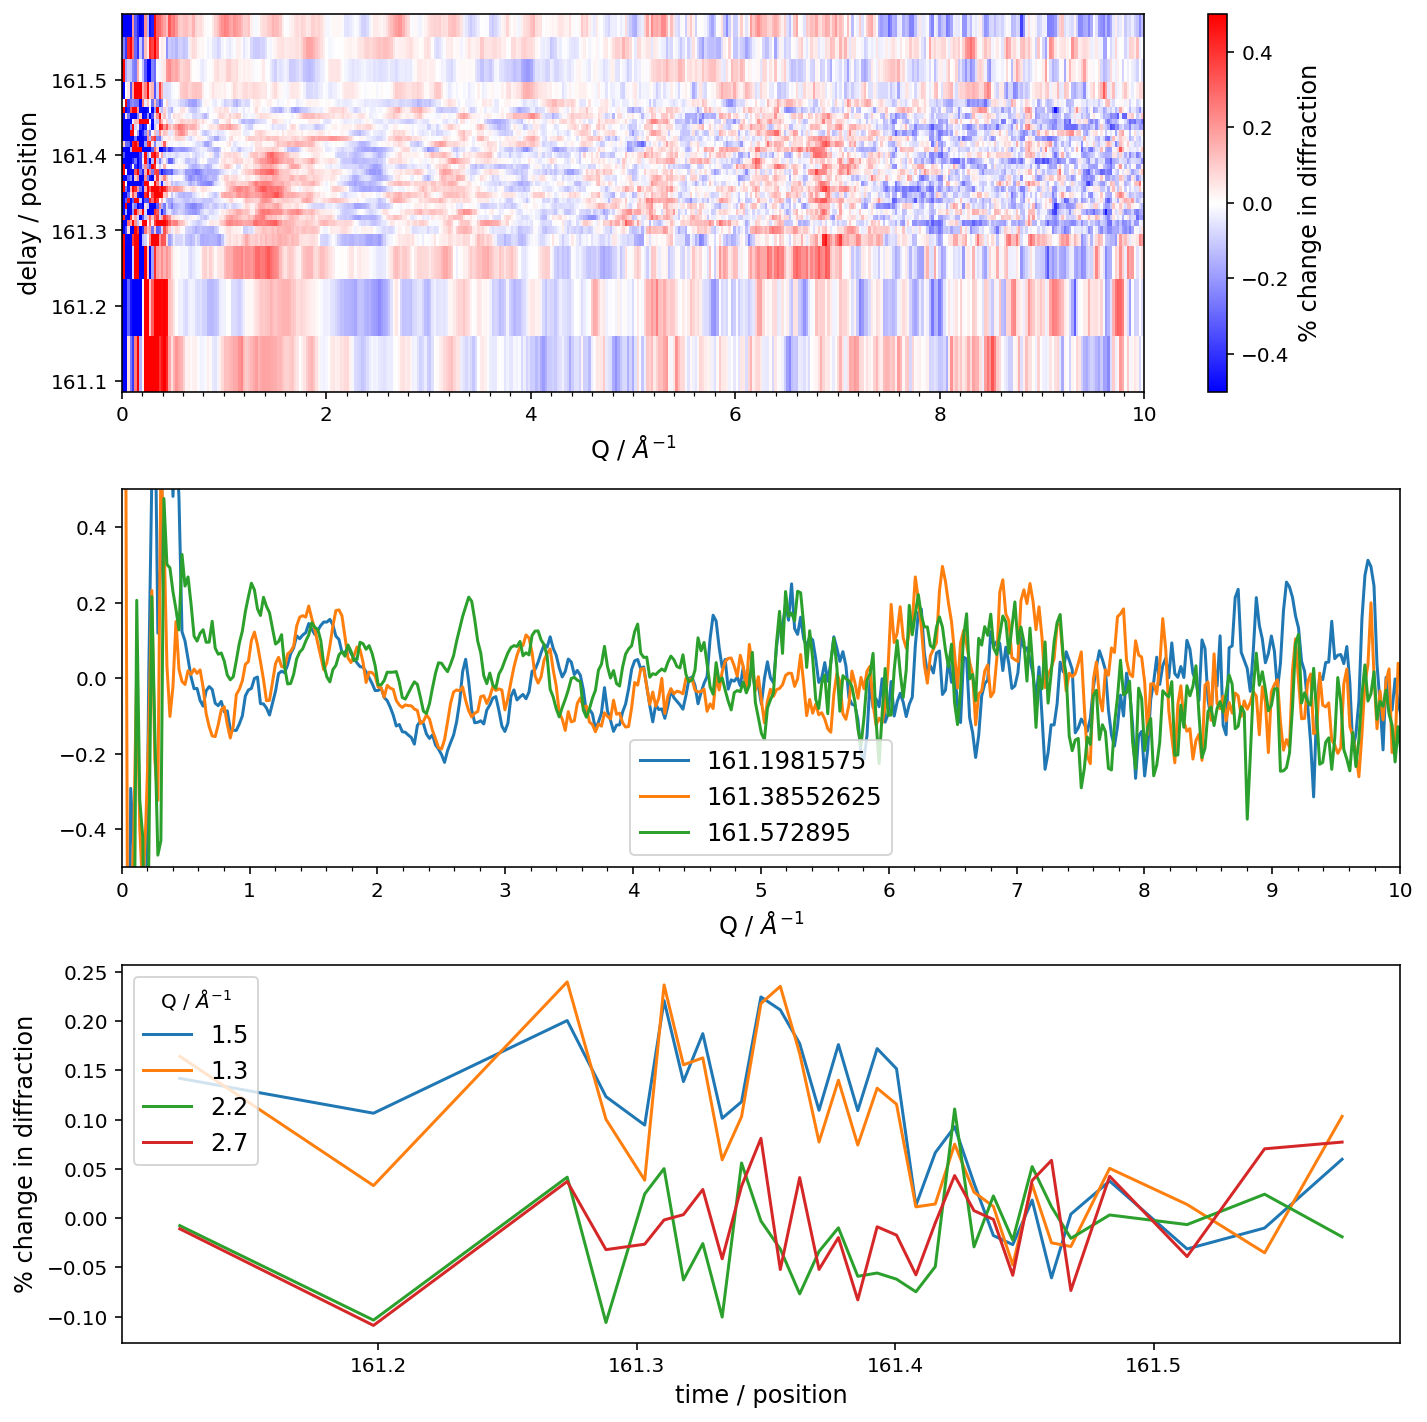

In [33]:
cmap = 'bwr'  #cmap = cm.PuBu_r
cart_pix = 300
delays = [1, len(Exp.delays_unique)//2, -1]
speclabels = [f'{Exp.delays_unique[step]}' for step in delays]
qs = [1.5, 1.3, 2.2, 2.7]
pixels = [ int(q/0.02355) for q in qs]
print(f"Q: {qs}, pixels: {pixels}")

fig, (ax1, ax3, ax4) = plt.subplots(ncols=1, nrows = 3, figsize=(10,10))

c = 299792458
t0 = 1000
taxis = t0 + (Exp.delays_unique-max(Exp.delays_unique))*2*c/1E5
qaxis = np.linspace(0,Exp.maxRadius*0.02355,Exp.maxRadius)
pd = pct_diff(Exp) # Labelled dI/I in the Matlab scripts,  (nSteps x nPixels) shape

#cartim1 = ax1.pcolormesh(qaxis,taxis,pd, shading='auto', cmap=cmap, vmin=-4, vmax=4)
cartim1 = ax1.pcolormesh(qaxis,Exp.delays_unique,pd, shading='auto', cmap=cmap, vmin=-0.5, vmax=0.5)
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.set_xlim(0,10)
ax1.set_xlabel('Q / $\AA^{-1}$', fontsize='large'), ax1.set_ylabel('delay / position', fontsize='large')
cbar = plt.colorbar(cartim1, ax=ax1)
cbar.set_label("% change in diffraction", fontsize='large')

spectr = np.transpose([pd[d] for d in delays])
ax3.plot(qaxis, spectr)
ax3.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.set_xlabel('Q / $\AA^{-1}$', fontsize='large'), ax4.set_ylabel('Change in diffraction', fontsize='large')#, ax4.set_aspect(1)
ax3.legend(speclabels, fontsize='large')
ax3.set_xlim(0,10)
ax3.set_ylim(-0.5,0.5)

transients = np.transpose([np.mean(pd[:,pix-10:pix+10],axis=1) for pix in pixels])
#ax4.plot(taxis, transients)
ax4.plot(Exp.delays_unique, transients)
ax4.set_xlabel('time / position', fontsize='large'), ax4.set_ylabel('% change in diffraction', fontsize='large')#, ax4.set_aspect(1)
ax4.legend(qs, fontsize='large', title='Q / $\AA^{-1}$')  

plt.tight_layout()
plt.show()
fig.savefig(f"{fn}_quads_pct_diff_fit_each_centers.pdf")  

subtracting delays -5 through -1
0.2662950709256584 6.722590454743383 2.2454817804395004
0.21804746285368048 6.803328257006529 1.8165405211378332
0.2928735738567208 13.591679341406216 3.128459590637432
0.2864614984161167 30.413543656346857 3.8301865699315862


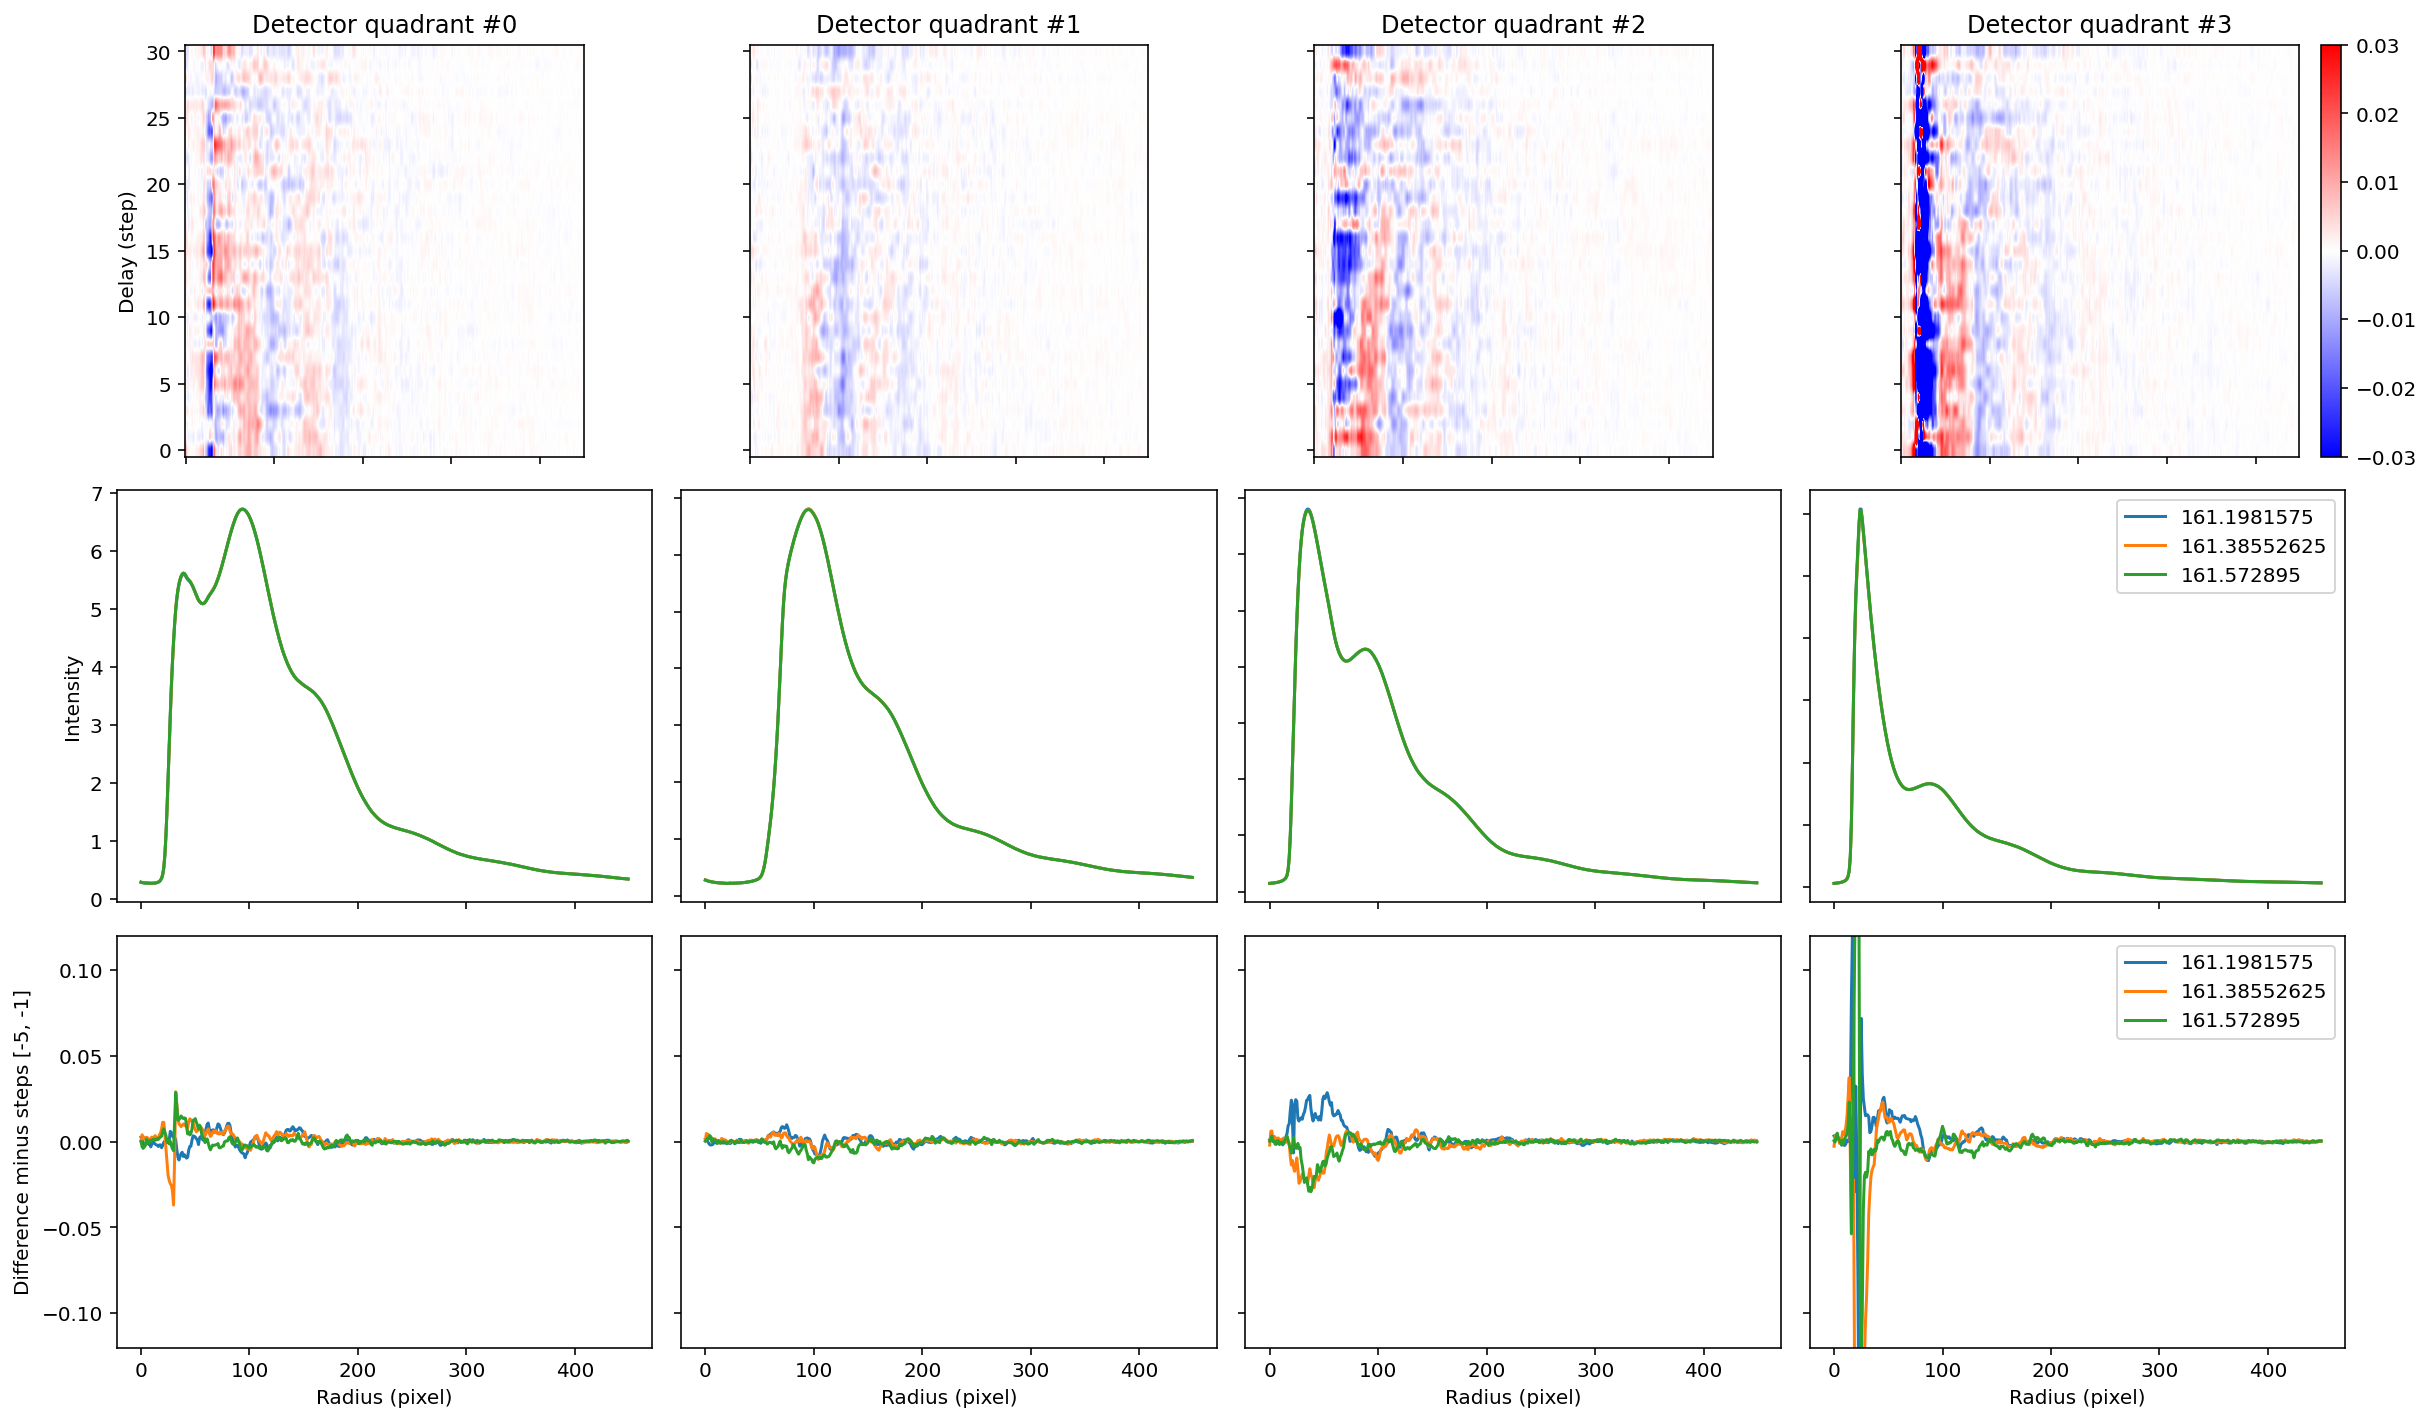

In [76]:
# BUG: why does running this script twice make bottom panel work? 
# BUG: The green background trace should not be zero, why does changing bkgnd_delays range fix it?

# Normalization helpful to visualize data
# Might need to use gridspec to control spacing and aspect ratio https://matplotlib.org/3.1.0/tutorials/intermediate/gridspec.html

delays = [1, len(Exp.delays_unique)//2, -1]
labels = [f'{Exp.delays_unique[step]}' for step in delays]
bkgnd_delays = [-5,-1]
print(f"subtracting delays {bkgnd_delays[0]} through {bkgnd_delays[1]}")

vmin, vmax = -0.03, 0.03
sub = True # see nothing without subtracting!
cmap = cm.bwr  #cmap = cm.PuBu_r

Nc = 4
fig, axs = plt.subplots(3, Nc, figsize=(17, 10))

images = []
cnt = 0

for quad in range(Nc):
        # Generate data with a range that varies from one plot to the next.
        data = []
        data2 = []
        data  = Exp.meanquadsN[:,:,quad].copy() # crucial we copy here or we just get a reference and then below edit it with -= !!!!
        data2 = Exp.meanquadsN[delays,:,quad].copy()
        
        bkgnd = []
        bkgnd = np.mean(Exp.meanquadsN[bkgnd_delays[0]:bkgnd_delays[1], :, quad].copy(),axis=0)
        print(np.min(bkgnd), np.max(bkgnd), np.mean(bkgnd))
        data_sub  = data - bkgnd
        data2_sub = data2 - bkgnd
            
        pltq = images.append(axs[0, quad].imshow(data_sub, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', aspect=15))
        images.append(axs[1, quad].plot(np.transpose(data2)))
        #images.append(axs[1, quad].plot(np.transpose(bkgnd))) # uncomment to plot the background contribution subtracted
        images.append(axs[2, quad].plot(np.transpose(data2_sub)))

        axs[0,quad].set_title('Detector quadrant #' + str(quad))
        axs[0,quad].set_xlabel('Radius (pixel)')
        axs[0,quad].set_ylabel('Delay (step)')
        axs[0,quad].label_outer()
        axs[1,quad].set_xlabel('Radius (pixel)')
        axs[1,quad].set_ylabel('Intensity')
        axs[1,quad].label_outer()
        #axs[1,quad].set_ylim(0,10)         
        axs[2,quad].set_xlabel('Radius (pixel)')
        axs[2,quad].set_ylabel(f'Difference minus steps {bkgnd_delays}')
        axs[2,quad].label_outer()
        axs[2,quad].set_ylim(-0.12,0.12)
        
        cnt +=1
        
#plt.colorbar(images[0], ax=axs[0,0],fraction=0.046, pad=0.04)
#plt.colorbar(images[0], ax=axs[0,1],fraction=0.046, pad=0.04)
#plt.colorbar(images[0], ax=axs[0,2],fraction=0.046, pad=0.04)
plt.colorbar(images[0], ax=axs[0,3],fraction=0.046, pad=0.04)
fig.tight_layout()
axs[1,3].legend(labels + ['bkgnd'])
axs[2,3].legend(labels)
plt.show()
fig.savefig(f"{fn}_quadrants.pdf")  